In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

import numpy as np
import pandas as pd
data_df = pd.read_csv("./TimeSeries.csv")
label_df = pd.read_csv("./labelsTimeSeries.csv")
df = data_df.copy()
df["label"] = label_df["label"]
arr = np.array(data_df)


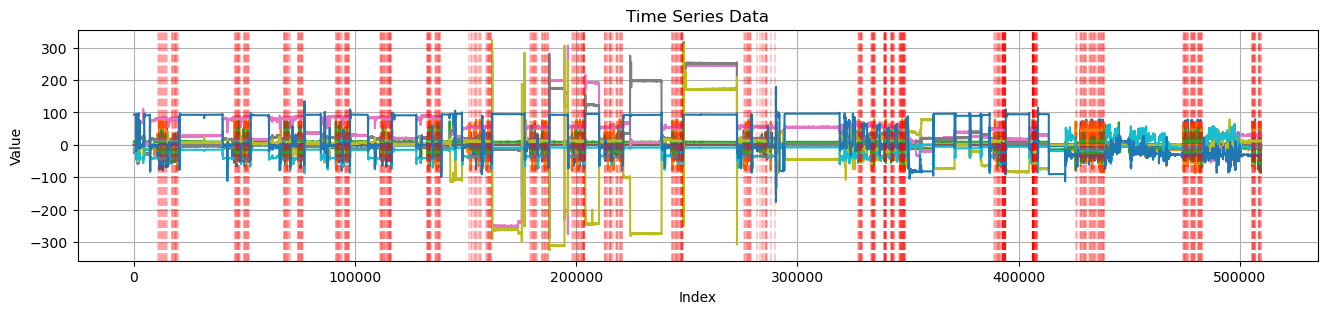

In [2]:
plt.figure(figsize = (16, 3))
for i in range(arr.shape[1]):
    plt.plot(arr[:, i])
plt.xlabel("Index")
plt.ylabel("Value")
plt.title("Time Series Data")
for pos in np.where(pd.read_csv("./labelsTimeSeries.csv")['label'] == 1)[0]:
    plt.axvline(x=pos, color='red', linestyle='--', alpha = .2)
# plt.legend()
plt.grid()
plt.show()

In [3]:
win_size = 60
windows = list()
for t in range(win_size, arr.shape[0]*3//4, win_size):
    if df['label'].iloc[t-win_size:t].any() == 1:
        continue
    windows += [arr[t - win_size:t, :]]
windows = np.stack(windows)
windows.shape

(6069, 60, 11)

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

class AutoEncoder(nn.Module):
    def __init__(self, input_dim, latent_dim=32):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, latent_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, input_dim)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

class AutoEncoderAgent:
    def __init__(self, input_dim, latent_dim=32, lr=1e-4):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(f"Using device: {self.device}")

        self.model = AutoEncoder(
            input_dim=input_dim, 
            latent_dim=latent_dim
        ).to(self.device)

        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=lr)

    def _calculate_loss(self, x, x_rec):
        return F.mse_loss(x, x_rec)

    def train(self, train_loader, total_epochs=50):
        print("--- Starting AutoEncoder Training ---")
        self.model.train()
        for epoch in range(total_epochs):
            total_loss = 0
            for i, (x_batch,) in enumerate(train_loader):
                x_batch = x_batch.to(self.device)
                
                self.optimizer.zero_grad()
                
                x_rec = self.model(x_batch)
                loss = self._calculate_loss(x_batch, x_rec)
                
                loss.backward()
                self.optimizer.step()
                
                total_loss += loss.item()
                
            print(f"Epoch {epoch+1}/{total_epochs}, Loss: {total_loss/len(train_loader):.6f}")

    def predict(self, test_loader):
        self.model.eval()
        anomaly_scores = []
        with torch.no_grad():
            for (x_batch,) in test_loader:
                x_batch = x_batch.to(self.device)
                
                x_rec = self.model(x_batch)
                
                score = torch.pow(x_batch - x_rec, 2).sum(dim=-1)
                anomaly_scores.append(score.cpu().numpy())
        
        return np.concatenate(anomaly_scores, axis=0)

In [5]:
# Example of how to use the agent
if __name__ == '__main__':
    # --- Dummy Parameters and Data for Demonstration ---
    BATCH_SIZE = 128
    SEQ_LEN = 9
    INPUT_DIM = 11
    
    # Create dummy data
    train_data = torch.tensor(windows, dtype = torch.float32)
    # test_data = torch.randn(BATCH_SIZE * 2, SEQ_LEN, INPUT_DIM)

    train_dataset = torch.utils.data.TensorDataset(train_data)
    # test_dataset = torch.utils.data.TensorDataset(test_data)

    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    # test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

    # --- Create and run the agent ---
        
    agent = AutoEncoderAgent(input_dim=INPUT_DIM,)

    # Train the model
    agent.train(train_loader, total_epochs=200) # Keep low for demo
    
    # Get anomaly scores
    scores = agent.predict(train_loader)
    
    print(f"\nTraining and prediction finished.")
    print(f"Shape of anomaly scores: {scores.shape}")

Using device: cuda
--- Starting AutoEncoder Training ---
Epoch 1/200, Loss: 3106.843455
Epoch 2/200, Loss: 2792.216504
Epoch 3/200, Loss: 1841.743388
Epoch 4/200, Loss: 870.370052
Epoch 5/200, Loss: 536.936450
Epoch 6/200, Loss: 435.101863
Epoch 7/200, Loss: 362.494845
Epoch 8/200, Loss: 267.602820
Epoch 9/200, Loss: 166.964395
Epoch 10/200, Loss: 111.068675
Epoch 11/200, Loss: 80.291495
Epoch 12/200, Loss: 57.995936
Epoch 13/200, Loss: 44.655421
Epoch 14/200, Loss: 34.831252
Epoch 15/200, Loss: 27.029081
Epoch 16/200, Loss: 20.578647
Epoch 17/200, Loss: 14.902871
Epoch 18/200, Loss: 10.989551
Epoch 19/200, Loss: 8.498969
Epoch 20/200, Loss: 6.904925
Epoch 21/200, Loss: 5.852690
Epoch 22/200, Loss: 5.144946
Epoch 23/200, Loss: 4.653299
Epoch 24/200, Loss: 4.295839
Epoch 25/200, Loss: 3.990393
Epoch 26/200, Loss: 3.736607
Epoch 27/200, Loss: 3.529189
Epoch 28/200, Loss: 3.318052
Epoch 29/200, Loss: 3.091414
Epoch 30/200, Loss: 2.932130
Epoch 31/200, Loss: 2.800341
Epoch 32/200, Loss: 2.

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Optional

def visualize_expanded_scores(window_scores: np.ndarray, arr: np.ndarray, label: np.ndarray, original_series_length: int, window_size: int, stride: int, threshold: Optional[float] = None, title: str = "Expanded Anomaly Scores Over Time"):
    
    # 創建兩個陣列：一個用於累加分數，一個用於計算每個時間步被多少個窗口覆蓋
    expanded_scores = np.zeros(original_series_length, dtype=float)
    counts = np.zeros(original_series_length, dtype=int)

    # 遍歷每個窗口的分數
    for i, score in enumerate(window_scores):
        # 計算當前窗口在原始序列中的起始和結束位置
        start_index = i * stride
        end_index = start_index + window_size
        
        # 將分數累加到對應的時間步上
        if end_index <= original_series_length:
            expanded_scores[start_index:end_index] += score
            counts[start_index:end_index] += 1
    
    # 對於被多個窗口覆蓋的時間步，計算平均分數
    # 處理分母為零的情況（雖然在典型情況下不會發生）
    counts[counts == 0] = 1
    final_scores_per_step = expanded_scores / counts

    print("Plotting the expanded scores...")
    # --- 視覺化 ---
    sns.set_style("whitegrid")
    fig, ax = plt.subplots(2, 1, figsize=(15, 6), sharex=True)
    
    # 繪製每個時間步的異常分數
    for i in range(arr.shape[1]):
        ax[0].plot(arr[:, i])
    
    I = np.where(label == 1)[0]
    for pos in I:
        ax[0].axvline(pos, color = "red", linestyle = "--", alpha = .2)
    ax[0].grid(color = "gray", linestyle = "--", alpha = .4)
    ax[1].plot(final_scores_per_step, label="Anomaly Score", color='dodgerblue', zorder=2)
    
    # 如果提供了閾值，繪製水平線
    if threshold is not None:
        ax[1].axhline(y=threshold, color='red', linestyle='--', label=f'Threshold ({threshold})', zorder=3)
        # 將高於閾值的部分標示出來，使其更清晰
        above_threshold = np.ma.masked_where(final_scores_per_step <= threshold, final_scores_per_step)
        ax[1].plot(above_threshold, color='orangered', linewidth=2.5, label='Anomaly Detected', zorder=4)

    ax[0].axvline(arr.shape[0]*3//4, color = "black", linewidth = 3)
    ax[1].axvline(arr.shape[0]*3//4, color = "black", linewidth = 3)
    
    plt.title(title, fontsize=16)
    plt.xlabel("Time Step", fontsize=12)
    plt.ylabel("Anomaly Score", fontsize=12)
    plt.tight_layout()
    plt.show()
    return final_scores_per_step

In [7]:
test_windows = list()
for t in range(win_size, arr.shape[0], win_size):
    test_windows += [arr[t - win_size:t, :]]
test_windows = np.stack(test_windows)
test_windows.shape

(8493, 60, 11)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 509632 entries, 0 to 509631
Data columns (total 12 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   v1      509632 non-null  float64
 1   v2      509632 non-null  float64
 2   v3      509632 non-null  float64
 3   v4      509632 non-null  float64
 4   v5      509632 non-null  float64
 5   v6      509632 non-null  float64
 6   v7      509632 non-null  float64
 7   v8      509632 non-null  float64
 8   v9      509632 non-null  float64
 9   v10     509632 non-null  float64
 10  v11     509632 non-null  float64
 11  label   509632 non-null  int64  
dtypes: float64(11), int64(1)
memory usage: 46.7 MB


Plotting the expanded scores...


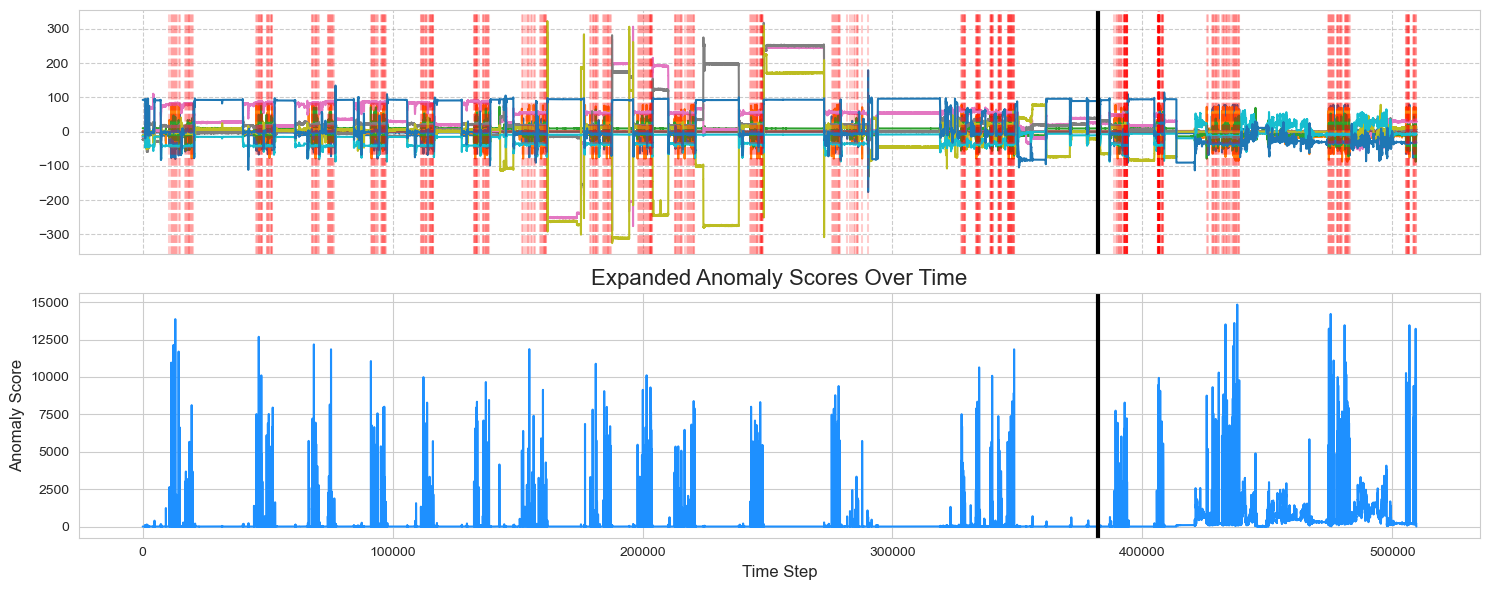

In [9]:
# Create dummy data
test_data = torch.tensor(test_windows, dtype = torch.float32)

test_dataset = torch.utils.data.TensorDataset(test_data)

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Get anomaly scores
scores = agent.predict(test_loader)

final_scores = visualize_expanded_scores(window_scores=scores,
                          arr = arr,
                          label = np.array(df['label']),
                          original_series_length=arr.shape[0], 
                          window_size=win_size, 
                          stride=win_size, 
                          threshold = None, 
                          title = "Expanded Anomaly Scores Over Time"
                          )


In [10]:
import numpy as np
import pandas as pd

def get_vus_score(y_true, y_score):
    if isinstance(y_true, (pd.Series, pd.DataFrame)):
        y_true = y_true.values.flatten()
    if isinstance(y_score, (pd.Series, pd.DataFrame)):
        y_score = y_score.values.flatten()

    def get_event_sequences(y):
        sequences = []
        is_event = False
        start_index = 0
        for i, val in enumerate(y):
            if val == 1 and not is_event:
                is_event = True
                start_index = i
            elif val == 0 and is_event:
                is_event = False
                sequences.append((start_index, i - 1))
        if is_event:
            sequences.append((start_index, len(y) - 1))
        return sequences
    
    true_anomalies = get_event_sequences(y_true)
    if not true_anomalies:
        return 0.0, np.array([0, 1]), np.array([1, 1])

    total_anomaly_length = np.sum([end - start + 1 for start, end in true_anomalies])
    if total_anomaly_length == 0:
        return 0.0, np.array([0, 1]), np.array([1, 1])

    normal_periods = []
    last_end = -1
    for start, end in true_anomalies:
        if start > last_end + 1:
            normal_periods.append((last_end + 1, start - 1))
        last_end = end
    if last_end < len(y_true) - 1:
        normal_periods.append((last_end + 1, len(y_true) - 1))
    
    num_normal_periods = len(normal_periods)
    if num_normal_periods == 0:
        return 1.0, np.array([0, 0]), np.array([1, 0])

    point_to_normal_id = np.full(len(y_true), -1, dtype=int)
    for i, (start, end) in enumerate(normal_periods):
        point_to_normal_id[start:end+1] = i

    sorted_indices = np.argsort(y_score)[::-1]
    sorted_scores = y_score[sorted_indices]
    
    vu_points = [1.0]
    sfpr_points = [0.0]
    thresholds = [np.inf]
    
    intersection_length = 0
    hit_normal_periods = np.zeros(num_normal_periods, dtype=bool)
    false_positive_subsequences = 0

    for i in range(len(sorted_indices)):
        idx = sorted_indices[i]
        
        if y_true[idx] == 1:
            intersection_length += 1
        else:
            normal_id = point_to_normal_id[idx]
            if not hit_normal_periods[normal_id]:
                hit_normal_periods[normal_id] = True
                false_positive_subsequences += 1

        if i == len(sorted_indices) - 1 or sorted_scores[i] != sorted_scores[i+1]:
            vu = 1 - (intersection_length / total_anomaly_length)
            sfpr = false_positive_subsequences / num_normal_periods
            vu_points.append(vu)
            sfpr_points.append(sfpr)
            thresholds.append(sorted_scores[i])

    vu_points = np.array(vu_points)
    sfpr_points = np.array(sfpr_points)
    
    unique_indices = np.where(np.diff(sfpr_points, prepend=np.nan))[0]
    sfpr_unique = sfpr_points[unique_indices]
    vu_unique = vu_points[unique_indices]
    
    if sfpr_unique[0] != 0:
        sfpr_unique = np.insert(sfpr_unique, 0, 0)
        vu_unique = np.insert(vu_unique, 0, 1)

    if sfpr_unique[-1] != 1 and num_normal_periods > 0:
         sfpr_unique = np.append(sfpr_unique, 1)
         vu_unique = np.append(vu_unique, vu_unique[-1])

    vus_score = np.trapz(vu_unique, sfpr_unique)
    
    return vus_score, sfpr_unique, vu_unique, thresholds


def plot_vus_curve(sfpr, vu, vus_score):
    import matplotlib.pyplot as plt
    import seaborn as sns
    sns.set_style("whitegrid")
    plt.figure(figsize=(8, 6))
    plt.plot(sfpr, vu, marker='.', linestyle='-', label=f'VUS Curve (AUC = {vus_score:.4f})', color='darkorange')
    plt.plot([0, 1], [1, 0], linestyle='--', color='navy', label='Reference Line')
    plt.fill_between(sfpr, vu, alpha=0.2, color='darkorange', step='pre')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Subsequence-wise False Positive Rate (sFPR)')
    plt.ylabel('Volume of Underestimation (VU)')
    plt.title('VUS Curve')
    plt.legend(loc='lower left')
    plt.show()

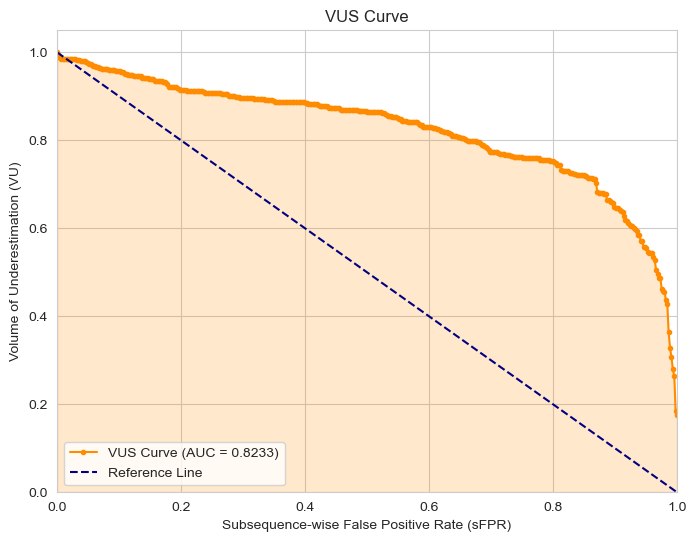

In [11]:
vus, sfpr, vu, thresholds = get_vus_score(np.array(df['label']), final_scores)
plot_vus_curve(sfpr, vu, vus)

In [12]:
def find_best_threshold_from_vus(y_true, y_score, thresholds, sfpr, vu):
    sfpr_points, vu_points, thresholds = sfpr, vu, thresholds
    
    if len(sfpr_points) == 0:
        print("無法計算閥值，可能因為沒有真實異常點。")
        return None, None, None

    # 計算每個點到理想點(0,0)的歐幾里得距離
    distances = np.sqrt(sfpr_points**2 + vu_points**2)
    
    # 找到距離最小的點的索引
    best_index = np.argmin(distances)
    
    best_threshold = thresholds[best_index]
    best_sfpr = sfpr_points[best_index]
    best_vu = vu_points[best_index]
    
    return best_threshold, best_sfpr, best_vu
find_best_threshold_from_vus(np.array(df['label']), final_scores, thresholds, sfpr, vu)

(9049.580078125, 0.1981981981981982, 0.9142212189616252)